## Clifford Fourier Transform for color images

This code corresponds the implementation described in:
"Color object recognition based on a clifford fourier transform". 
Jose Mennesson, Christophe Saint-Jean, and Laurent Mascarilla. 
In book "Guide to Geometric Algebra in Practice". Springer, 2011.

Python code here is an adaptation of Matlab code by the previous authors.

### Mathematical description

In [1]:
!pip3 install galgebra requests

In [2]:

from galgebra import *

# to be completed

### Signal processing implementation

In [16]:
from matplotlib.pyplot import imread 

## Get Image from file
def image_from_file(filename): 
    return imread(filename)
## Get Image for url
def image_from_url(url):
    from requests import get
    from io import BytesIO   
    return image_from_file(BytesIO(get(url).content))[:,:,:3]

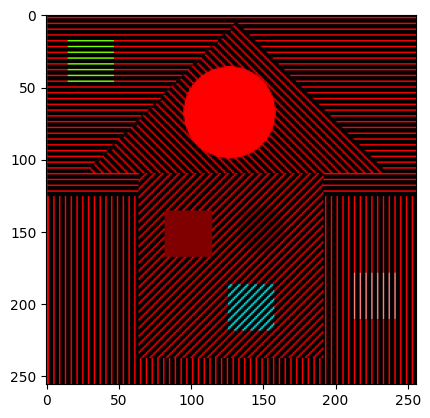

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
urls =['https://hal.archives-ouvertes.fr/hal-00332912v2/file/Fhouse_color.png',
       'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png']
image = image_from_url(urls[0])
plt.imshow(image)
plt.show()
 

In [5]:
import numpy as np

def get_basis(c1, c2 = None):
    """ Returns an orthonormal direct basis of R_{4,0}^1 """
    c1 /= np.linalg.norm(c1)
    if c2 is None:         # ~c1 ^ e4, c3 ^ c4 (orthogonal plane to c1 in R^3) 
        mu = np.ones(3)
        if np.allclose(np.cross(c1, mu), np.zeros(3)):
            mu = np.array([1.,0.,0.])
        c3 = np.cross(c1,np.cross(mu,c1))
        c3 /= np.linalg.norm(c3)
        c4 = np.cross(c1, c3)
        assert(np.allclose(np.linalg.norm(c4), 1.))
        return np.append(c1,0.), np.array([0,0,0,1.]), np.append(c3,0.), np.append(c4,0.)
    else:                 # ~c1 ^ ~c2, c3 ^ e4 (c3 orthogonal to plane ~c1 ^ ~c2 in R^3) 
        c3 = np.cross(c1, c2)
        c3 /= np.linalg.norm(c3)
        c2 = -np.cross(c1, c3)
        assert(np.allclose(np.linalg.norm(c2), 1.))
        return np.append(c1,0), np.append(c2,0), np.append(c3,0), np.array([0,0,0,1.])

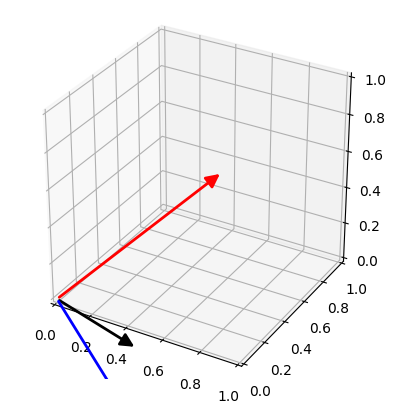

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs) 


B = get_basis(np.array([1.,1.,1.]))
ax = plt.figure().add_subplot(projection='3d')
ax.set_aspect("equal")
colors = "rgbk"
for b, col in zip(B, colors):
    a = Arrow3D([0, b[0]], [0, b[1]], [0, b[2]] , mutation_scale=20, lw=2, arrowstyle="-|>", color=col)
    ax.add_artist(a)
plt.show()

In [7]:
B

(array([0.57735027, 0.57735027, 0.57735027, 0.        ]),
 array([0., 0., 0., 1.]),
 array([ 0.81649658, -0.40824829, -0.40824829,  0.        ]),
 array([ 0.        ,  0.70710678, -0.70710678,  0.        ]))

In [8]:
def cfft2(image, basis, reconstruction = False):
    h,l,chan = image.shape
    if chan == 4:
        pass
    elif chan == 3:
        image = np.dstack((image, np.zeros((h,l)))) # add a fourth component with 0
    else:
        raise ValueError
    # Computation of two FFT2s on the two projected Image
    output = { 'parallel' : np.fft.fft2(np.dot(image, basis[0]) + 1j*np.dot(image, basis[1])),
              'orthogonal': np.fft.fft2(np.dot(image, basis[2]) + 1j*np.dot(image, basis[3]))}
    if reconstruction is True:
        output['reconstruction'] =\
            np.outer(output['parallel'].real,basis[0]) +\
            np.outer(output['parallel'].imag, basis[1]) +\
            np.outer(output['orthogonal'].real, basis[2]) +\
            np.outer(output['orthogonal'].imag, basis[3])
        output['reconstruction'] = np.reshape(output['reconstruction'],(h,l,4))
    return output


In [9]:
def icfft2(tf_image, basis):
    if 'parallel' in tf_image:
        h,l = tf_image['parallel'].shape
        _ = np.fft.ifft2(tf_image['parallel'])
        image = np.outer(_.real, basis[0])
        image += np.outer(_.imag, basis[1])
        _ = np.fft.ifft2(tf_image['orthogonal'])
        image += np.outer(_.real, basis[2])
        image += np.outer(_.imag, basis[3])      
    elif 'reconstruction' in tf_image:
        _ = tf_image['reconstruction']
        return icfft2({'parallel' : np.dot(_, basis[0]) + 1j* np.dot(_, basis[1]),
                       'orthogonal' : np.dot(_, basis[2]) + 1j* np.dot(_, basis[3])}, basis)
    elif fft_image.shape[2] == 4:
        return icfft2({'reconstruction' : tf_image}, basis)
    else:
        raise ValueError  
    return np.reshape(image, (h,l,4))

In [10]:
import ipywidgets as widgets

r_slider = widgets.IntSlider(min=0, max=255, step=1, value=255)
g_slider = widgets.IntSlider(min=0, max=255, step=1, value=0)
b_slider = widgets.IntSlider(min=0, max=255, step=1, value=0)
    
def f(r,g,b):
    basis = get_basis(np.array([r,g,b], dtype=np.double))
    R = cfft2(image, basis)
    IR = icfft2(R, basis)
    fig, ax = plt.subplots(2, 2, figsize=(10, 6)) 
    ax[0,0].imshow(image)
    ax[0,0].set_title('Original image')
    ax[1,0].imshow(np.log(1+np.abs(np.fft.fftshift(R['parallel']))), plt.cm.Blues)
    ax[1,0].set_title('Spectrum in first basis (parallel)')
    ax[1,1].imshow(np.log(1+np.abs(np.fft.fftshift(R['orthogonal']))), plt.cm.Blues)
    ax[1,1].set_title('Spectrum in second basis (orthogonal)')
    ax[0,1].imshow(IR[:,:,:3])
    ax[0,1].set_title('Reconstructed image')
              
widgets.interact(f, r=r_slider, g=g_slider, b=b_slider)

interactive(children=(IntSlider(value=255, description='r', max=255), IntSlider(value=0, description='g', max=…

<function __main__.f(r, g, b)>

### Speed considerations

In [11]:
basis = get_basis(np.array([1,0,0], dtype=np.double))
%timeit icfft2(cfft2(image, basis), basis)

9.04 ms ± 66.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
!jupyter nbconvert --to html CFFT.ipynb

[NbConvertApp] Converting notebook CFFT.ipynb to html
[NbConvertApp] Writing 1091982 bytes to CFFT.html
